<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

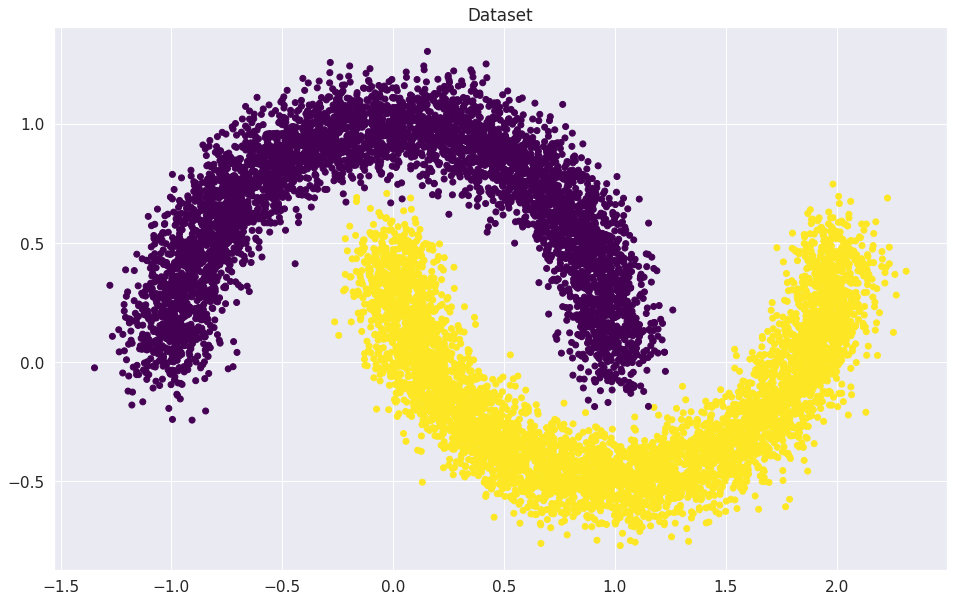

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
#переводим из массива numpy в тензор, меняем тип на  torch.float32.
X_train_t=torch.from_numpy(X_train).to(torch.float32)
y_train_t =  torch.from_numpy(y_train).to(torch.float32)
X_val_t =  torch.from_numpy(X_val).to(torch.float32)
y_val_t =  torch.from_numpy(y_val).to(torch.float32)

In [ ]:
#проверим что мы правильно привели к типу
print(X_train_t.dtype)
print(y_train_t.dtype)
print(X_val_t.dtype)
print(y_val_t.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


Создаем `Dataset` и `DataLoader`. 

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128) 
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = torch.nn.Parameter(torch.randn(out_features, in_features)) #задаем параметры
        self.bias = bias
        if bias:
            self.bias_term = torch.nn.Parameter(torch.randn(out_features)) #задаем смещение

    def forward(self, x):
        x =  x @ self.weights.t() #перемножаем матрицы
        if self.bias:
            x += self.bias_term #добавляем "свободный член"
        return x

In [ ]:
linear_regression = LinearRegression(2,1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [ ]:
count_w=torch.numel(linear_regression.weights) #количество весов
count_bias=torch.numel(linear_regression.bias_term) #количество смещений
print(count_w+count_bias) #выведем суммарное количество параметров

3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression.forward(X_batch) # возвращаем логиты 
        loss =  loss_function(outp,y_batch.view(y_batch.size(0), -1))#Считаем лосс, Момент с .view(y_batch.size(0), -1) нужен так как последний батч размера не 128 а 76.
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) #считаем обычной сигмоидой
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5546875
Iteration: 100
Batch accuracy: 0.8671875
Iteration: 200
Batch accuracy: 0.84375
Iteration: 300
Batch accuracy: 0.921875
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.9140625

Iteration: 519.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 519


### Визуализируем результаты

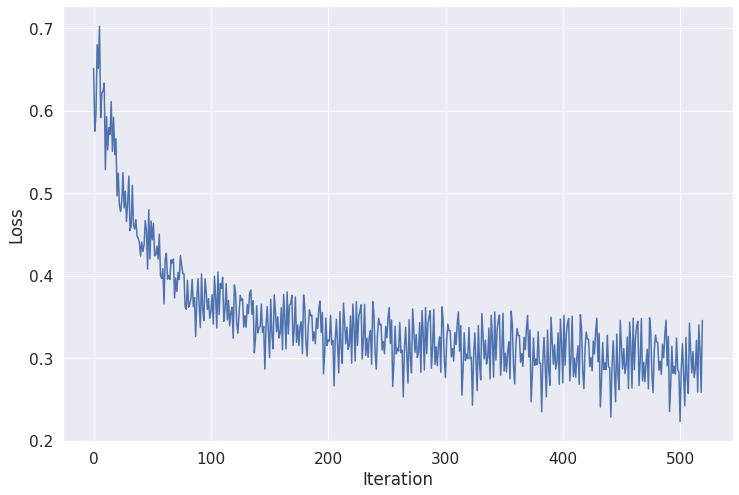

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

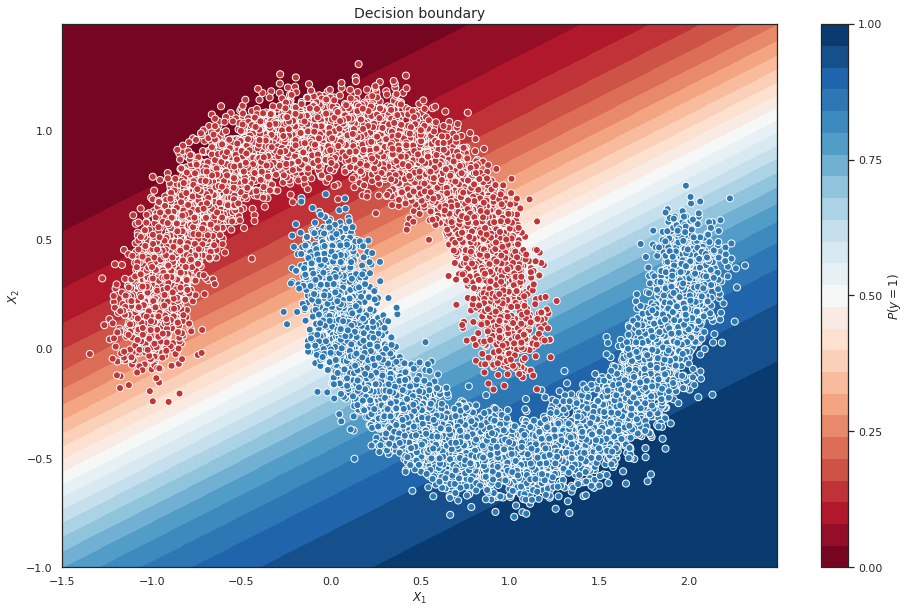

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp =  model.forward(x_batch) #считаем логиты
        probabilities = torch.sigmoid(outp) #берем сигмоиду
        preds = (probabilities>0.5).type(torch.long) #вычисляем наши preds аналогично предыдущему заданию
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val_t,predict(val_dataloader,linear_regression))

0.872

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.872

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)
batch_size=128
train_dataloader =  DataLoader(train_dataset, batch_size=batch_size, drop_last=True)#последний батч может быть размера не 128,поэтому выкинем его для удобства  
valid_dataloader =  DataLoader(val_dataset, batch_size=batch_size, drop_last=True)#здесь сделаем так же

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
activation = nn.ELU
features=784 #28*28 рамзер картинки
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features,128), # первый скрытый слой 
    activation(), # активация
    nn.Linear(128,128), #второй скрытый слой
    activation(), # активация
    nn.Linear(128,10) # выходной слой
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()  # переводим в режим train
                optimizer.zero_grad() # обнуляем градиенты
                outp = model(x_batch)#считаем логиты
            else:
                model.eval() #переводим в режим eval
                with torch.no_grad():  #НЕ считаем градиенты
                    outp = model(x_batch) # получаем логиты
            preds = outp.argmax(-1)
            correct =torch.tensor(y_batch[y_batch==preds].size())#количество правильно угаданных 
            all = batch_size #количество элементов в батче
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
               loss = criterion(outp, y_batch)#считаем лосс
               loss.backward() #считаем градиенты бэк пропагейшном
               optimizer.step()# делаем шаг градиентного спуска
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8790898771367521
Loader: valid. Accuracy: 0.9260817307692307
Epoch: 2
Loader: train. Accuracy: 0.9409054487179487
Loader: valid. Accuracy: 0.9520232371794872
Epoch: 3
Loader: train. Accuracy: 0.9586672008547008
Loader: valid. Accuracy: 0.9613381410256411
Epoch: 4
Loader: train. Accuracy: 0.9676816239316239
Loader: valid. Accuracy: 0.9657451923076923
Epoch: 5
Loader: train. Accuracy: 0.9736578525641025
Loader: valid. Accuracy: 0.9689503205128205
Epoch: 6
Loader: train. Accuracy: 0.9781483707264957
Loader: valid. Accuracy: 0.9708533653846154
Epoch: 7
Loader: train. Accuracy: 0.9822215544871795
Loader: valid. Accuracy: 0.9698517628205128
Epoch: 8
Loader: train. Accuracy: 0.984375
Loader: valid. Accuracy: 0.9638421474358975
Epoch: 9
Loader: train. Accuracy: 0.9859274839743589
Loader: valid. Accuracy: 0.9609375
Epoch: 10
Loader: train. Accuracy: 0.9863782051282052
Loader: valid. Accuracy: 0.9667467948717948


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = accuracy["valid"]

In [ ]:
#обернем наш цикл обучения для удобства в функцию training_cycle,которая возвращает массив accuracy["valid"]
def training_cycle(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()  # переводим в режим train
                    optimizer.zero_grad() # обнуляем градиенты
                    outp = model(x_batch)#считаем логиты
                else:
                    model.eval() #переводим в режим eval
                    with torch.no_grad():  #НЕ считаем градиенты
                        outp = model(x_batch) # получаем логиты
                preds = outp.argmax(-1)
                correct =torch.tensor(y_batch[y_batch==preds].size())#количество правильно угаданных 
                all = batch_size #количество элементов в батче
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                  loss = criterion(outp, y_batch)#считаем лосс
                  loss.backward() #считаем градиенты бэк пропагейшном
                  optimizer.step()# делаем шаг градиентного спуска
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]
  

In [ ]:
def test_activation_function(activation):
  #собираем модель для заданной функции активации
  models = nn.Sequential( 
    nn.Flatten(),
    nn.Linear(784,128),
    activation(), 
    nn.Linear(128,128), 
    activation(), 
    nn.Linear(128,10)) 
  return training_cycle(models) #возвращаем результат обучения модели


    

In [ ]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

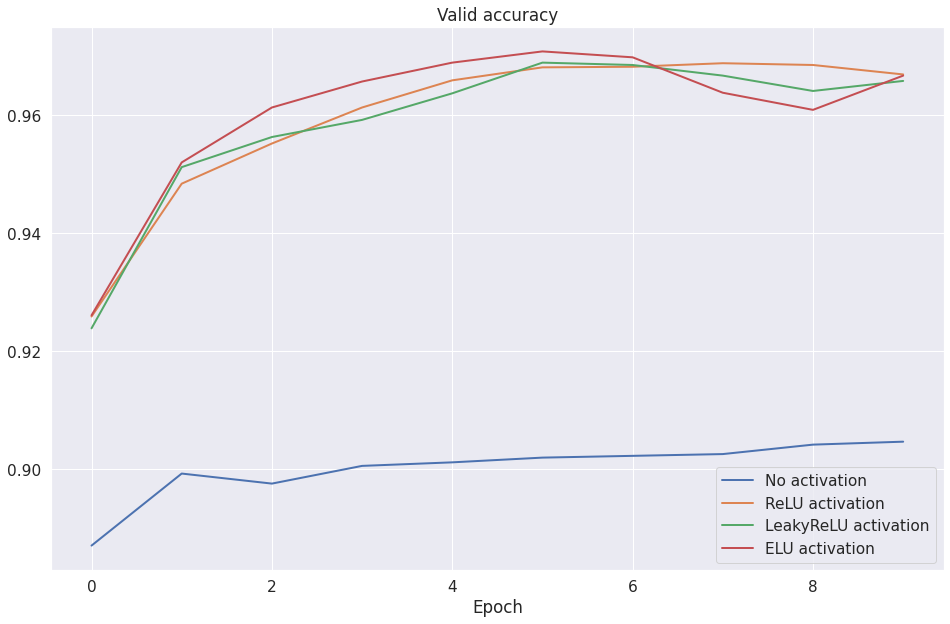

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-12-05 09:41:37--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-12-05 09:41:37--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   266KB/s    in 0.2s    

2021-12-05 09:41:38 (266 KB/s) - ‘sample_photo.jpg’ saved [49337/4

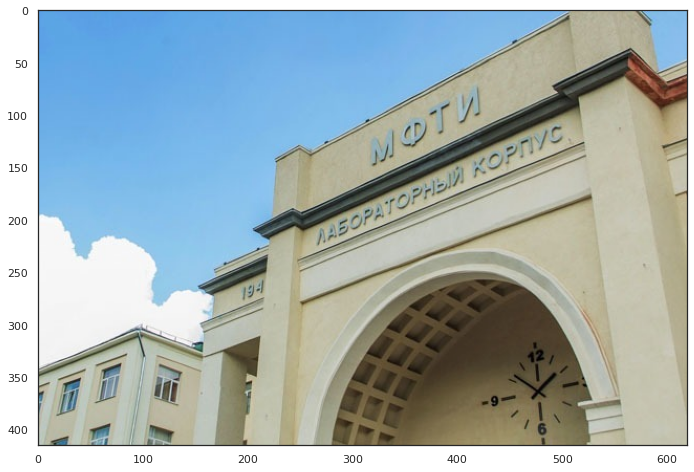

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

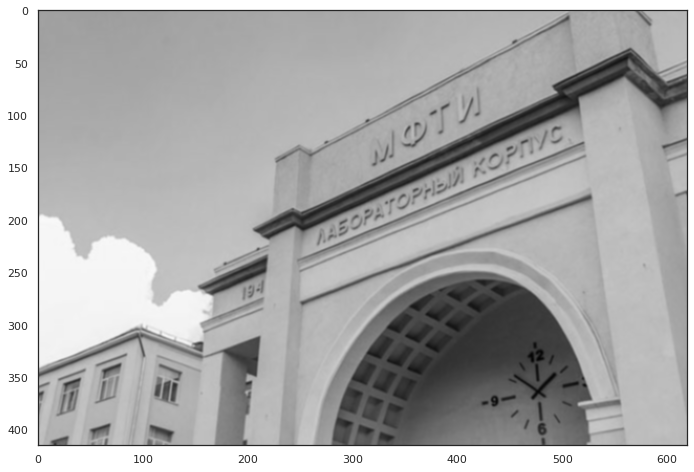

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()


**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** А-3, 
           Б-5,
           В-4,
           Г-6,
           Д-2,
           Е-1


### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
import torch.nn.functional as F

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape) #посмотрели какой аргумент ставить в in_features на первом линейном слое
        x = x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
#тут искал аргумент для in_features на первом линейном слое как в семинаре 16*5*5
net = LeNet()
batch = []


batch = next(iter(train_dataloader))

net.forward(torch.FloatTensor(batch[0]))
batch=0

torch.Size([128, 16, 5, 5])


In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
#Проведем обучение через нашу функцию training_cycle(), написанную выше,тогда изменим немного код ниже

In [ ]:
lenet_accuracy = training_cycle(model) #функция как раз вернет нужный нам accuracy["valid"]

Сравним с предыдущем пунктом

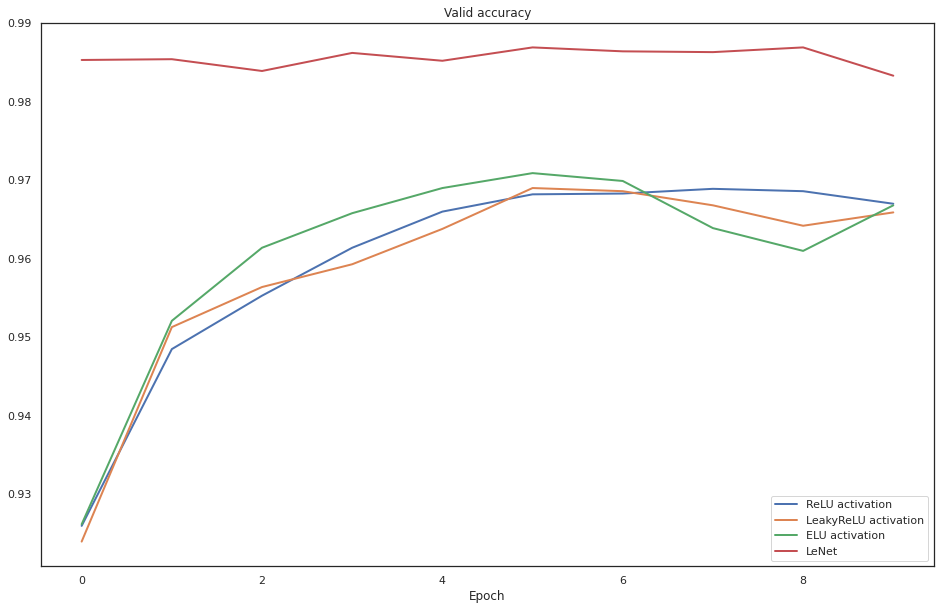

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
lenet_accuracy[9] # выведем accuracy после последней эпохи.На 9-10 эпохах результат хуже, чем на 8.Видимо пошло переобучение.По условию задачи берем все-таки последний результат 

0.9832732371794872

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.98